In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import seaborn as sns

In [2]:
print(np.__version__)

1.19.1


In [3]:
import pytorch_lightning as pl

C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [4]:
df = pd.read_excel('data.xlsx', skiprows=2)

In [5]:
df.head(10).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#008080'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'),
            ('color', 'black')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#DCDCDC')]}, 
 
 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
  'props': [('background', 'yellow')]},
]).hide_index()

data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
2019-02-01 00:00:00,2019-02-02 00:00:00,1,208.830000,2006.800000,212.320000,1066.200000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,2,201.000000,2270.500000,204.090000,1155.600000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,3,195.000000,2644.800000,191.370000,1256.000000,195.00,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,4,189.000000,2355.700000,188.380000,1192.700000,190.25,20.00
2019-02-01 00:00:00,2019-02-02 00:00:00,5,189.260000,2324.500000,189.680000,1260.800000,190.25,20.00
2019-02-01 00:00:00,2019-02-02 00:00:00,6,191.210000,2364.900000,190.340000,1233.500000,191.50,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,7,203.000000,2264.200000,205.730000,1095.300000,203.00,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,8,213.810000,2199.400000,212.720000,1139.400000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,9,229.000000,2279.300000,220.410000,625.900000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,10,242.760000,2721.300000,228.160000,934.500000,-,-


In [6]:
df.shape

(9504, 9)

In [7]:
df['year'] = pd.DatetimeIndex(df['data obrotu']).year
df['month'] = pd.DatetimeIndex(df['data obrotu']).month
df['day'] = pd.DatetimeIndex(df['data obrotu']).day

In [8]:
df_ = pd.DataFrame({'year': df['year'],
                     'month': df['month'],
                     'day': df['day']})

In [9]:
df['godzina dostawy'] = pd.to_numeric(df['godzina dostawy'], errors='coerce')

In [10]:
df['godzina dostawy'].isnull().sum()

1

In [11]:
df = df.dropna()

In [12]:
df['date'] = pd.to_datetime(df_) + pd.to_timedelta(df['godzina dostawy'], unit='h')

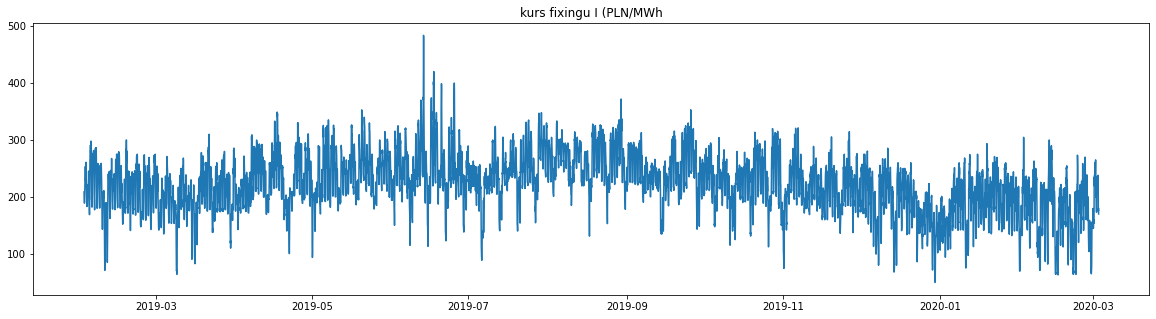

In [13]:
plt.figure(figsize=(20,5))
plt.plot(df['date'], df['kurs fixingu I (PLN/MWh)'])
plt.title("kurs fixingu I (PLN/MWh")
params = {"ytick.color" : "w",
          "xtick.color" : "white",
          "axes.labelcolor" : "white",
          "axes.edgecolor" : "white"
        }
plt.rcParams.update(params)
plt.show()

In [14]:
df = pd.DataFrame(data={'Date': df['date'], 'Kurs fixing':df['kurs fixingu I (PLN/MWh)']})

In [15]:
price = df[['Kurs fixing']]
scaler = MinMaxScaler(feature_range=(-1, 1))
# price['Kurs fixing'] = scaler.fit_transform(price['Kurs fixing'].values.reshape(-1,1))
price['Kurs fixing'] = scaler.fit_transform(price['Kurs fixing'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
price

,Kurs fixing
0,-0.266914
1,-0.302988
2,-0.330630
3,-0.358273
4,-0.357075
...,...
9499,-0.169381
9500,-0.307595
9501,-0.422773
9502,-0.399737


In [17]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    print(data_raw)
    print(len(data_raw))
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [18]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

[[-0.26691392]
 [-0.30298772]
 [-0.33063049]
 ...
 [-0.42277303]
 [-0.39973739]
 [-0.44580867]]
9503


In [19]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
#Hyper-parametres
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [22]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.06255221366882324
Epoch  1 MSE:  0.04508690908551216
Epoch  2 MSE:  0.04919463396072388
Epoch  3 MSE:  0.045987535268068314
Epoch  4 MSE:  0.04188483580946922
Epoch  5 MSE:  0.0399320088326931
Epoch  6 MSE:  0.03949277475476265
Epoch  7 MSE:  0.03825477138161659
Epoch  8 MSE:  0.034520868211984634
Epoch  9 MSE:  0.02950100600719452
Epoch  10 MSE:  0.028222737833857536
Epoch  11 MSE:  0.026991482824087143
Epoch  12 MSE:  0.023316772654652596
Epoch  13 MSE:  0.02555599994957447
Epoch  14 MSE:  0.021446339786052704
Epoch  15 MSE:  0.019104938954114914
Epoch  16 MSE:  0.019062863662838936
Epoch  17 MSE:  0.018403561785817146
Epoch  18 MSE:  0.016707899048924446
Epoch  19 MSE:  0.015133993700146675
Epoch  20 MSE:  0.014147943817079067
Epoch  21 MSE:  0.013163757510483265
Epoch  22 MSE:  0.011669785715639591
Epoch  23 MSE:  0.010450635105371475
Epoch  24 MSE:  0.010172651149332523
Epoch  25 MSE:  0.009335449896752834
Epoch  26 MSE:  0.00802669022232294
Epoch  27 MSE:  0.0075

In [24]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

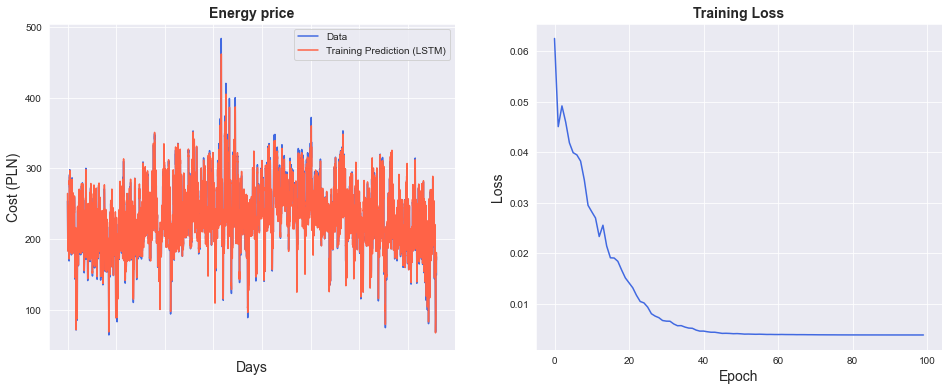

In [28]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Energy price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (PLN)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)